# Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 5)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [16, 5]
pal = plt.get_cmap('Paired').colors

from tqdm import tqdm, tqdm_notebook
import quandl

In [3]:
from utils import *

In [8]:
# api_key = open(file='quandl_api').read().replace('\n', '')
# quandl.ApiConfig.api_key = api_key
tickers, prices = get_quandl_sharadar(free=True)
prices = prices.assign(Set='free')
# tickers, prices = get_sharadar_train()
# prices = prices.query('Set == "train"')

In [9]:
prices

,,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set
Ticker,Date,,,,,,,,,
AAPL,1998-12-31,1.446,1.478,1.411,1.462,67922400.0,0.0,40.94,2018-06-19,free
AXP,1998-12-31,34.967,35.100,34.100,34.167,2528700.0,0.0,102.50,2018-02-11,free
...,...,...,...,...,...,...,...,...,...,...
WMT,2018-07-10,85.930,87.330,85.880,87.210,6029353.0,0.0,87.21,2018-07-10,free
XOM,2018-07-10,83.700,84.120,83.510,83.660,8767599.0,0.0,83.66,2018-07-10,free


In [10]:
ticker_days = prices.groupby('Ticker')[['Set']].count().rename(columns={'Set': 'n_days'}).reset_index()

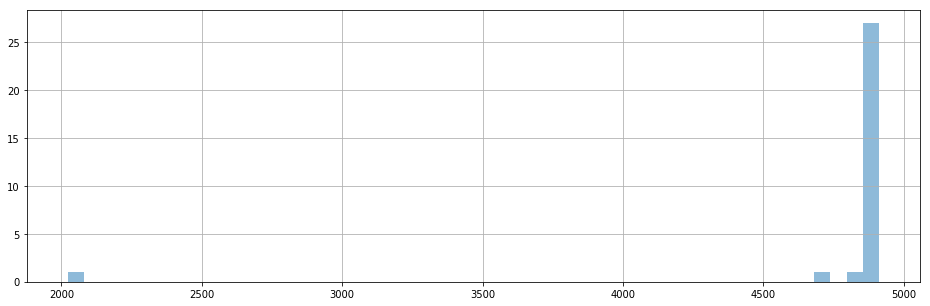

In [11]:
ticker_days.n_days.hist(bins=50, alpha=0.5)

# Finding the trend in a single price

See An introduction to smoothing time series in python, [part 1](http://www.nehalemlabs.net/prototype/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/) and [part 2](http://www.nehalemlabs.net/prototype/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/).

Series to check:

* AKTC

4912 days.


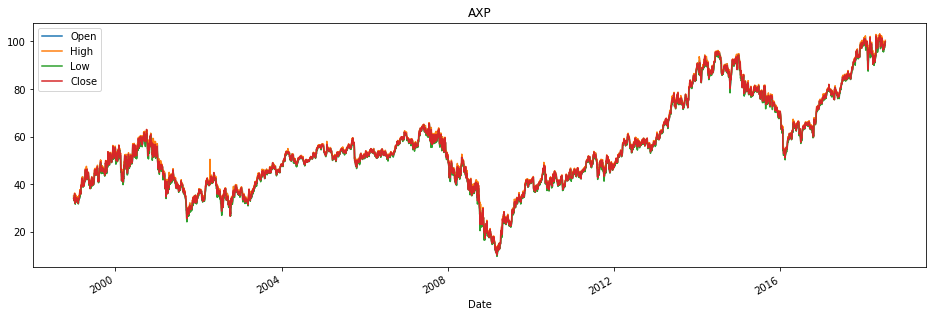

In [12]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title(ticker);

## Filters

In [13]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

### Linear 

In [14]:
N = 61
f_sma = np.ones(N) / N

### Gaussian

In [57]:
N_ga = 1500
f_ga = gaussian(N_ga, std=30.)
f_ga = f_ga / f_ga.sum()

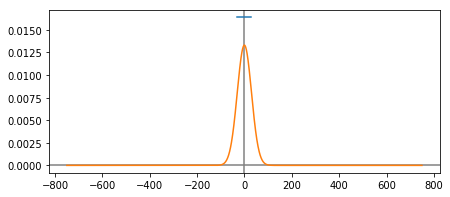

In [58]:
plt.figure(figsize=(7, 3))
plt.axhline(c='grey')
plt.axvline(c='grey')
plt.plot(np.arange(-N/2, N/2), f_sma, label='f_sma')
plt.plot(np.arange(-N_ga/2, N_ga/2), f_ga, label='f_ga')
plt.show()

### Geometric

In [51]:
f_geo = lambda s: np.exp(filters.convolve1d(np.log(price.Close), f_ga))

### Wiener 

In [34]:
sigma = np.std(price.Close)
f_wi = lambda x: wiener(x, mysize=N, noise=sigma)

### Spline

In [35]:
f_sp = lambda x: UnivariateSpline(np.arange(len(x)), x)(np.arange(len(x)))

### Results

<Figure size 1152x432 with 0 Axes>

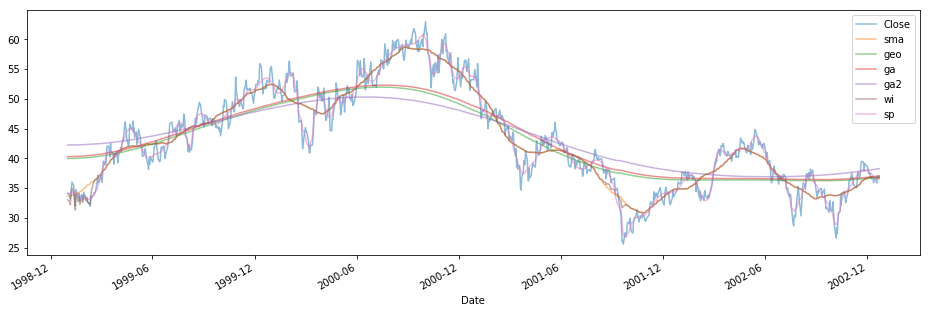

In [54]:
plt.figure(figsize=(16, 6))
results = price[['Close']].assign(
    sma=filters.convolve1d(price.Close, f_sma),
    geo=f_geo(price.Close),
    ga=filters.convolve1d(price.Close, f_ga),
    ga2=filters.convolve1d(filters.convolve1d(price.Close, f_ga), f_ga),
    wi=f_wi(price.Close),
    sp=f_sp(price.Close),
)
results[:1000].plot(alpha=0.5);

<Figure size 1152x432 with 0 Axes>

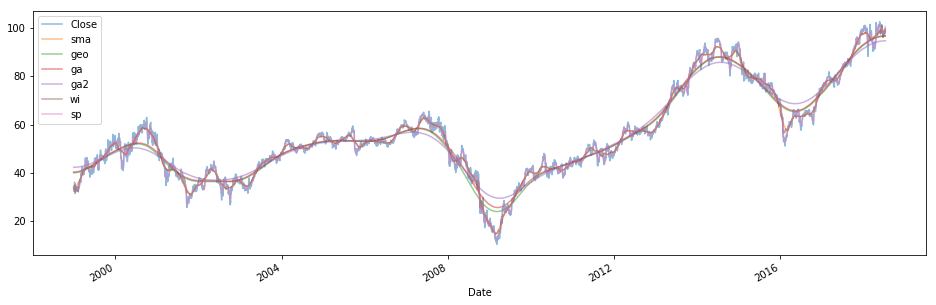

In [55]:
plt.figure(figsize=(16, 6));
results.plot(alpha = 0.5);

In [56]:
def smooth_price(df, N=151, std=20.):
    f_ga = gaussian(N_ga, std=std)
    f_ga = f_ga / f_ga.sum()
    df = df.assign(Smoothed=filters.convolve1d(df.Close, f_ga))
    
    return df

## Trends 

### Peaks and Valleys

In [ ]:
from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import confusion_matrix

In [ ]:
results = smooth_price(price)

In [ ]:
results

In [ ]:
results = results.assign(Trend=np.nan, Max_Drawdown=np.nan)
peaks, _ = find_peaks(results.Smoothed)
valleys, _ = find_peaks(-results.Smoothed)

In [ ]:
n_changes = min(len(peaks), len(valleys))
assert len(set(np.sign(peaks[:n_changes] - valleys[:n_changes]))) == 1

In [ ]:
# End
if valleys.max() > peaks.max():
    peaks = np.concatenate((peaks, np.ones(1, dtype=np.int32) * len(results) - 1))
else:
    valleys = np.concatenate((valleys, np.ones(1, dtype=np.int32) * len(results) - 1))

In [ ]:
peaks

In [ ]:
results.loc[results.index[peaks], 'Trend'] = 1
results.loc[results.index[valleys], 'Trend'] = -1
results.Trend.fillna(method='bfill', inplace=True)

In [ ]:
results

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

### Slopes

In [ ]:
results = results.assign(Trend2=results.Smoothed.pct_change().apply(np.sign))
results.loc[results.index[0], 'Trend2'] = results.Trend2[1]

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend2 up')
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend2 down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

In [ ]:
confusion_matrix(results.Trend.values, results.Trend2) / len(results)

> Both methods are equivalent!!

## Max drawdown within trend

-> For trailing stop-loss orders...

In [ ]:
breakpoints = np.concatenate((np.zeros(1, dtype=np.int32), peaks + 1, valleys + 1))
breakpoints.sort()
print('Breakpoints:', breakpoints)

In [ ]:
b = 3
trend_start = breakpoints[b - 1]
trend_end = breakpoints[b]
res_b = results[trend_start:trend_end]
res_b

In [ ]:
for b in range(1, len(breakpoints)):

    trend_start = breakpoints[b - 1]
    trend_end = breakpoints[b]
    res_b = results[trend_start:trend_end]
    trend_b = res_b.Trend[0]

    # Adjust for position (long, short)
    close_b = res_b.Close[0] * res_b.Close.pct_change()[1:].mul(trend_b).add(1).cumprod()  
    close_b[res_b.index[0]] = res_b.Close[0]
    close_b = close_b.sort_index()

    peak = close_b[0]
    low = peak
    drawdown = 0
    max_drawdown = 0

    for i in range(1, len(close_b)):
        # Max drawdown
        if close_b[i] > peak:
            peak = close_b[i]
            low = peak
        if close_b[i] < low:
            low = close_b[i]
            drawdown = low / peak - 1
        max_drawdown = min(drawdown, max_drawdown)
    
    results.loc[res_b.index, 'Max_Drawdown'] = -max_drawdown
    

In [ ]:
results

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results.Close, label='Close')
plt.plot(results.Close * (1 - results.Max_Drawdown * results.Trend), label='Stop-loss')
plt.axhline(0, c='grey')
plt.legend()
plt.title(ticker)
plt.show()

In [ ]:
res2 = find_trends(price)
plot_trends(res2)

# Sample...

## A single asset 

In [165]:
from utils import *
ticker = np.random.choice(tickers)
# ticker = 'AEE'
price = prices.loc[ticker]
print(len(price), 'days.')

212 days.


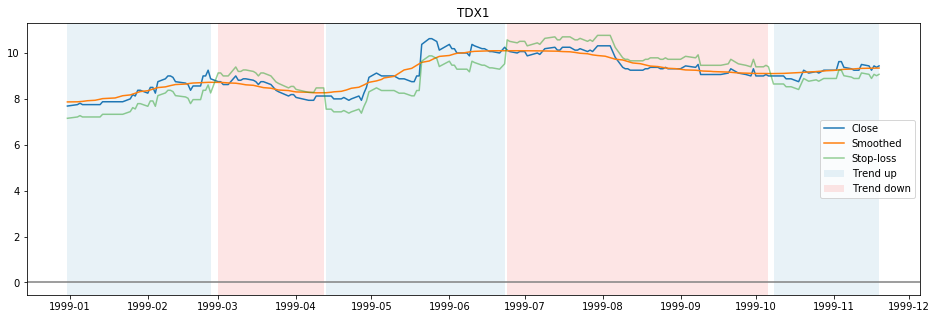

In [166]:
trends = find_trends(price, sd=10., N=1500)
plot_trends(trends, ticker)

In [167]:
DataFrame(trends.groupby('n_Trend').Trend.count().describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
Trend,5.0,42.4,16.622274,28.0,29.0,38.0,49.0,68.0


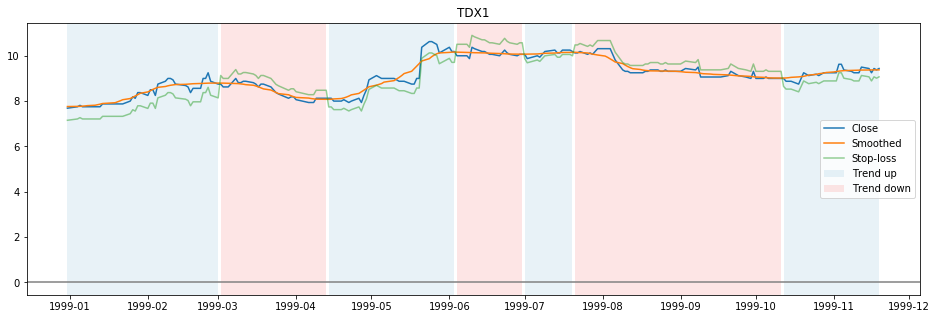

In [169]:
trends2 = find_trends(price, sd=5.)
plot_trends(trends2, ticker)

In [170]:
DataFrame(trends2.groupby('n_Trend').Trend.count().describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
Trend,7.0,30.285714,13.437687,12.0,23.0,28.0,36.5,53.0


In [171]:
def summarise_trends(df, sd=20.):
    trends = find_trends(df, sd)
    res = DataFrame(trends.groupby('n_Trend').Trend.count().describe())
    res = res.transpose().assign(sd = sd).set_index('sd')
    
    return res

In [172]:
sds = np.arange(5, 150, step=30)
sum_trends = pd.concat([summarise_trends(price, s) for s in sds], axis=0)

AssertionError: 

In [ ]:
sum_trends

In [ ]:
sum_trends[['mean', 'min', '50%', 'max']].plot()

In [ ]:
sum_trends[['count']].plot()

## Multiple assets

### Single thread

In [135]:
from utils import *
# summarise_trends(prices.loc['A'], sd=100)
# results = pickle.load(open('output/Finding the trends - sd values for filtering.pickle', 'rb'))

In [136]:
n_tickers = 100
sds = np.arange(10, 210, step=10)

results = []
grouped = prices.loc[np.random.choice(tickers, size=n_tickers)].groupby('Ticker')
# grouped = prices.loc[list(set(results_df.Ticker.values))].groupby('Ticker')

for name, group in tqdm_notebook(grouped, desc='Ticker:'):
    
    res_g = []
    for s in tqdm_notebook(sds, desc='sd:', leave=False):
        try:
            res_g.append(summarise_trends(group, s, 500))
        except:
            pass
    try:
        results.append(pd.concat(res_g, axis=0).assign(Ticker=name))
    except:
        pass

In [59]:
pickle.dump(results, open('output/Finding the trends - sd values for filtering.pickle', 'wb'))

### Parallel (TO DO...)

In [7]:
import ipyparallel as ipp

rc = ipp.Client()
rc[:].use_dill()
rc.ids

[0, 1, 2, 3, 4, 5, 6]

In [8]:
%%px --local
import itertools
import numpy
import pandas
from pandas import Series, DataFrame
from datetime import datetime
import matplotlib
from matplotlib import pyplot
import matplotlib.transforms
import trading_strategies
from utils import *

In [9]:
# view = rc.load_balanced_view()
dview = rc[:]

In [10]:
grouped = prices.loc[np.random.choice(tickers, size=5)].groupby('Ticker')

def aux_sum_trend(gr_item):
    sds = np.arange(5, 20, step=5)
    group, name = gr_item
    sum_trends = pd.concat([summarise_trends(group, s) for s in sds], axis=0)
    sum_trends = sum_trends.assign(Ticker=name)
    
    return sum_trends

In [11]:
dview.scatter('l_grouped', list(grouped))

<AsyncResult: scatter>

In [12]:
%%px 
y = [aux_sum_trend(i) for i in l_grouped]

NameError: name 'l_grouped' is not defined

CompositeError: one or more exceptions from call to method: execute
[0:execute]: NameError: name 'l_grouped' is not defined
[1:execute]: NameError: name 'l_grouped' is not defined
[2:execute]: NameError: name 'l_grouped' is not defined
[3:execute]: NameError: name 'l_grouped' is not defined
.... 3 more exceptions ...

### Results

In [137]:
results_df = pd.concat(results, axis=0, sort=True)
results_df = results_df.assign(trend_freq=364.25*results_df['count'].astype(np.float64)/results_df.n_days.astype(np.float64))

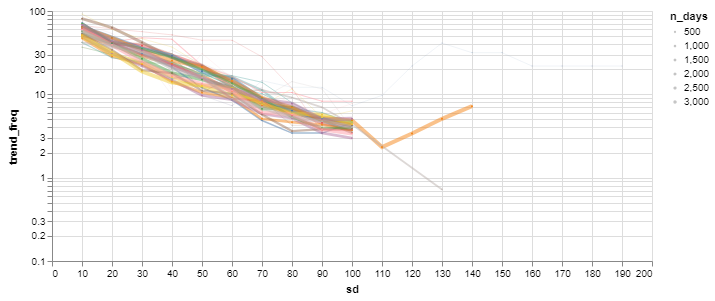

In [138]:
import altair as alt
alt.renderers.enable('notebook')
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y=alt.Y('trend_freq', scale=alt.Scale(type='log')), #y='trend_freq',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=600,
    height=250
).interactive()

# TO DO:

* Asset selection.
  * By small or negative change correlations.
  * Highest signal to noise ratios (see Kaufman, 2005, pp. 870).
* Exit by volume (~extreme reduction, bankrupt, ...).
* Feature engineering.
  * c.f. fast.ai's `add_datepart` function.